In [39]:
import math, os, random, time

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
def seed(seed=42):
    random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
seed(42)

cuda


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
from dataclasses import dataclass

@dataclass
class CFG:
    data_root: str = "./data"
    img_size: int = 28
    batch_size: int = 256
    num_workers: int = 4

    K: int = 10
    sigma_min: float = 0.01
    sigma_max: float = 1.0

    epochs: int = 250
    lr: float = 2e-4
    weight_decay: float = 0.0
    log_interval: int = 100

    ald_c: float = 0.1
    ald_T_per_level: int = 100
    n_sample: int = 64
        
cfg = CFG()
print(cfg)

CFG(data_root='./data', img_size=28, batch_size=256, num_workers=4, K=10, sigma_min=0.01, sigma_max=1.0, epochs=250, lr=0.0002, weight_decay=0.0, log_interval=100, ald_c=0.1, ald_T_per_level=100, n_sample=64)


In [41]:
from torchvision import datasets, transforms, utils
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root=cfg.data_root, train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=True, drop_last=True)

print("Batches:", len(train_loader))

Batches: 234


In [ ]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, dim=128):
        super().__init__()
        self.dim = dim
        half = dim//2
        freqs = torch.exp(torch.linspace(math.log(1.0), math.log(10000.0), half))
        self.register_buffer("freqs", freqs, persistent=False)

    def forward(self, sigma):
        x = torch.log(sigma).unsqueeze(-1)
        angles = x * self.freqs
        emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)
        if emb.shape[-1] < self.dim:
            emb = F.pad(emb, (0, self.dim - emb.shape[-1]))
        return emb

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, emb_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.gn1 = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.gn2 = nn.GroupNorm(8, out_ch)
        self.emb_proj = nn.Linear(emb_ch, out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, emb):
        h = self.conv1(x)
        h = self.gn1(h)
        h = F.silu(h)

        e = self.emb_proj(emb).unsqueeze(-1).unsqueeze(-1)
        h = h + e
        h = self.conv2(h)
        h = self.gn2(h)
        h = F.silu(h)

        return h + self.skip(x)

class UNet(nn.Module):
    # 28x28 - 14x14 - 7x7 - 14x14 - 28x28
    def __init__(self, in_ch=1, base_ch=64, emb_ch=128):
        super().__init__()
        self.emb = SinusoidalEmbedding(dim=emb_ch)
        self.emb_out = nn.Sequential(
            nn.Linear(emb_ch, emb_ch), nn.SiLU(),
            nn.Linear(emb_ch, emb_ch)
        )

        # encoder
        self.in_conv = nn.Conv2d(in_ch, base_ch, 3, padding=1)
        self.rb1 = Block(base_ch, base_ch, emb_ch)
        self.down1 = nn.Conv2d(base_ch, base_ch*2, 4, stride=2, padding=1)
        self.rb2 = Block(base_ch*2, base_ch*2, emb_ch)
        self.down2 = nn.Conv2d(base_ch*2, base_ch*4, 4, stride=2, padding=1)
        self.rb3 = Block(base_ch*4, base_ch*4, emb_ch)

        # midddle
        self.mid = Block(base_ch*4, base_ch*4, emb_ch)

        # decoder
        self.up1 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 4, stride=2, padding=1)
        self.rb4 = Block(base_ch*4, base_ch*2, emb_ch)  # concatanate skip
        self.up2 = nn.ConvTranspose2d(base_ch*2, base_ch, 4, stride=2, padding=1)
        self.rb5 = Block(base_ch*2, base_ch, emb_ch)
        self.out = nn.Conv2d(base_ch, in_ch, 3, padding=1)

    def forward(self, x, sigma):
        emb = self.emb_out(self.emb(sigma))

        x0 = F.silu(self.in_conv(x))
        x1 = self.rb1(x0, emb)
        x2 = F.silu(self.down1(x1))
        x2 = self.rb2(x2, emb)
        x3 = F.silu(self.down2(x2))
        x3 = self.rb3(x3, emb)

        m = self.mid(x3, emb)

        u1 = F.silu(self.up1(m))
        u1 = torch.cat([u1, x2], dim=1)
        u1 = self.rb4(u1, emb)

        u2 = F.silu(self.up2(u1))
        u2 = torch.cat([u2, x1], dim=1)
        u2 = self.rb5(u2, emb)
        return self.out(u2)

In [ ]:
def make_sigma(K, sigma_min, sigma_max):
    return torch.linspace(sigma_max, sigma_min, steps=K)

sigmas = make_sigma(cfg.K, cfg.sigma_min, cfg.sigma_max).to(device)

def sample_sigmas(batch_size):
    idx = torch.randint(0, len(sigmas), (batch_size,), device=device)
    return sigmas[idx]  # per batch one sigma

def dsm_loss(model, x):
    B = x.size(0)
    sigma = sample_sigmas(B)
    noise = torch.randn_like(x)  #  same size as image B,1,H,W
    x_tilda = x + sigma.view(B,1,1,1) * noise  # noisy image

    score_pred = model(x_tilda, sigma)

    target = -(x_tilda - x)/(sigma.view(B,1,1,1)**2)
    diff = score_pred - target

    per_example = (diff**2).flatten(1).mean(dim=1)  # shape B
    weights = (sigma**2)
    loss = (weights * per_example).mean()
    return loss

In [45]:
model = UNet(in_ch=1, base_ch=64, emb_ch=128).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

/tmp/ipykernel_112868/2646005195.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


In [46]:
losses = []
steps = 0
model.train()

for epoch in range(1, cfg.epochs+1):
    t0 = time.time()
    for i, (x, _) in enumerate(train_loader):
        x = x.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            loss = dsm_loss(model, x)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        losses.append(loss.item())
        steps += 1

        if steps % cfg.log_interval == 0:
            print(f"epoch {epoch:02d} step {steps:05d} dsm_loss {loss.item():.4f}")

print("Training Complete")


/tmp/ipykernel_112868/3215440086.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


epoch 01 step 00100 dsm_loss 0.2383
epoch 01 step 00200 dsm_loss 0.1865
epoch 02 step 00300 dsm_loss 0.1543
epoch 02 step 00400 dsm_loss 0.1544
epoch 03 step 00500 dsm_loss 0.1126
epoch 03 step 00600 dsm_loss 0.1206
epoch 03 step 00700 dsm_loss 0.1173
epoch 04 step 00800 dsm_loss 0.0795
epoch 04 step 00900 dsm_loss 0.0859
epoch 05 step 01000 dsm_loss 0.0778
epoch 05 step 01100 dsm_loss 0.0947
epoch 06 step 01200 dsm_loss 0.0710
epoch 06 step 01300 dsm_loss 0.0719
epoch 06 step 01400 dsm_loss 0.0732
epoch 07 step 01500 dsm_loss 0.0733
epoch 07 step 01600 dsm_loss 0.0688
epoch 08 step 01700 dsm_loss 0.0723
epoch 08 step 01800 dsm_loss 0.0740
epoch 09 step 01900 dsm_loss 0.0715
epoch 09 step 02000 dsm_loss 0.0652
epoch 09 step 02100 dsm_loss 0.0694
epoch 10 step 02200 dsm_loss 0.0698
epoch 10 step 02300 dsm_loss 0.0633
epoch 11 step 02400 dsm_loss 0.0674
epoch 11 step 02500 dsm_loss 0.0626
epoch 12 step 02600 dsm_loss 0.0699
epoch 12 step 02700 dsm_loss 0.0709
epoch 12 step 02800 dsm_loss

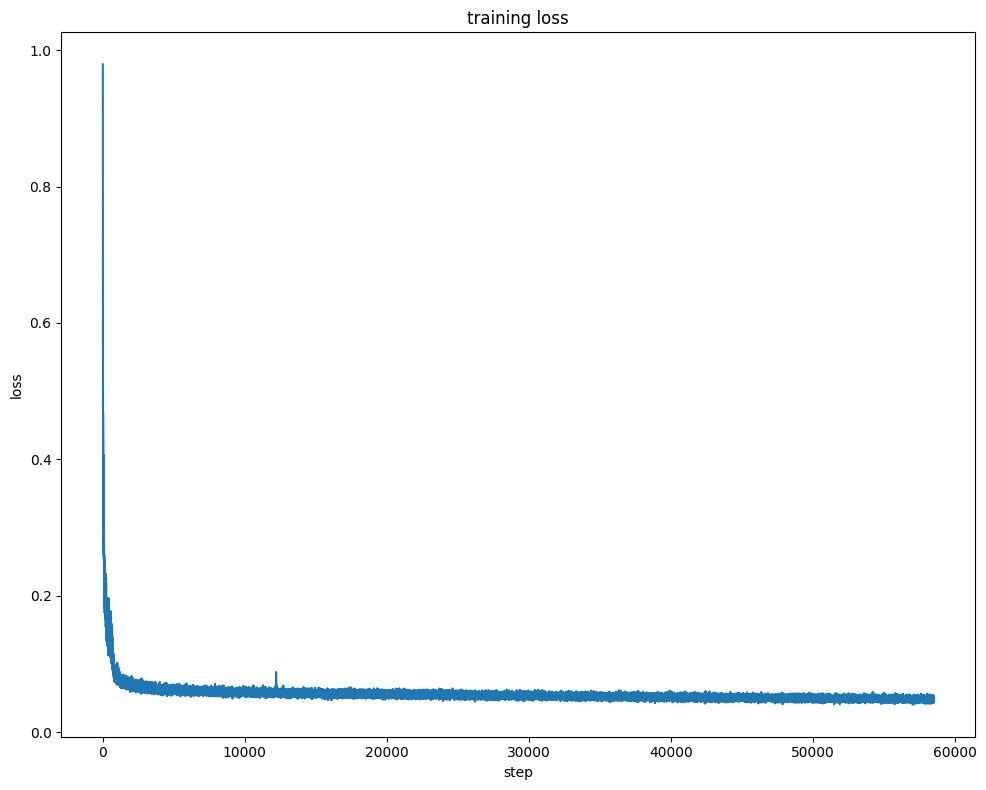

In [47]:
plt.figure(figsize=(10,8))
plt.plot(losses)
plt.title("training loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
plt.show()


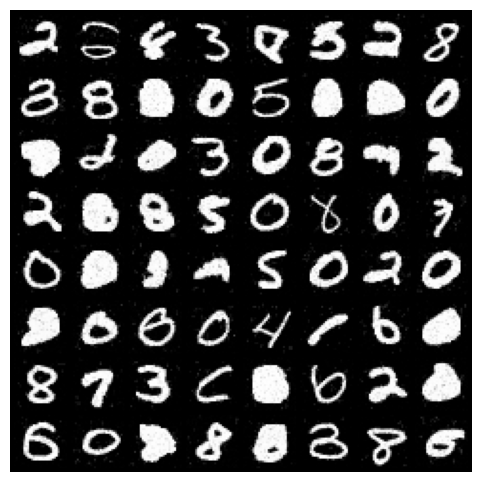

In [48]:
# Annealed Langevin Dynamics sampler
@torch.no_grad()
def sample_ald(model, n=64, sigmas=sigmas, ald_c=0.1, T_per_level=100):
    model.eval()
    x = torch.randn(n, 1, cfg.img_size, cfg.img_size, device=device)  # start from N(0,I), n - batch size

    for sigma in sigmas:
        alpha_t = ald_c * (sigma**2)  # how much to move in gradient dir
        for i in range(T_per_level):
            z = torch.randn_like(x)
            s = model(x, torch.full((n,), sigma, device=device))
            x = x + alpha_t*s + (2.0*alpha_t) ** 0.5*z

    x = x.clamp(-1, 1)
    return x

samples = sample_ald(model, n=cfg.n_sample, sigmas=sigmas, ald_c=cfg.ald_c, T_per_level=cfg.ald_T_per_level)
grid = utils.make_grid((samples + 1)/2, nrow=int(math.sqrt(cfg.n_sample)))
plt.figure(figsize=(6,6)); plt.axis('off'); plt.imshow(grid.permute(1,2,0).cpu()); plt.show()

os.makedirs("samples", exist_ok=True)
utils.save_image((samples+1)/2, "samples/mnist_ald_samples.png", nrow=int(math.sqrt(cfg.n_sample)))

In [49]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

@torch.no_grad()
def compute_is_fid(model, loader, n_eval=5000, batch=128):
    model.eval()
    fid = FrechetInceptionDistance(normalize=False).to(device)
    ins = InceptionScore(normalize=False).to(device)

    def to_rgb_uint8(x):
        if x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1)
        x = x.clamp(-1, 1)
        x = (x + 1) / 2
        x = (x * 255.0).round().to(torch.uint8)
        return x

    added = 0
    for x, _ in loader:
        x = x.to(device)
        real = to_rgb_uint8(x)
        fid.update(real, real=True)
        n = min(batch, x.size(0))
        fake = sample_ald(model, n=n)
        fake = to_rgb_uint8(fake)
        fid.update(fake, real=False)
        ins.update(fake)

        added += n
        if added >= n_eval:
            break

    is_mean, is_std = ins.compute()
    fid_score = fid.compute()
    return float(is_mean), float(is_std), float(fid_score)

is_m, is_s, fid_s = compute_is_fid(model, train_loader)
print(f"Inception Score: {is_m:.2f}±{is_s:.2f} FID: {fid_s:.2f}")

Inception Score: 2.18±0.04 FID: 103.49
